# ECE 351 - Lab #10
## Frequency Response
### Introduction
The purpose of this lab is to familiarize ourselves with the tools availabile in Python to analyze frequency responses of systems.

### Part 1

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import control
import warnings
warnings.filterwarnings("ignore")

# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray", "purple", "orange"]
step_size = 10

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=["Plot"], num_rows=1, size=(16, 12), mode="Norm"):
    plt.figure(figsize=size, dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(
        zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            if mode is "Norm":
                plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            else:
                plt.semilogx(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
    
    plt.show()

In [2]:
r = 1000
l = 27e-3
c = 100e-9
def h_mag(w):
    return (20*np.log10((w/(r*c) / (np.sqrt((1/(l*c)-w*w)**2 + (w/(r*c))**2)))))

def h_phase(w):
    return (np.degrees(np.pi/2 - np.arctan((w/(r*c)) / (1/(l*c)-w*w))))

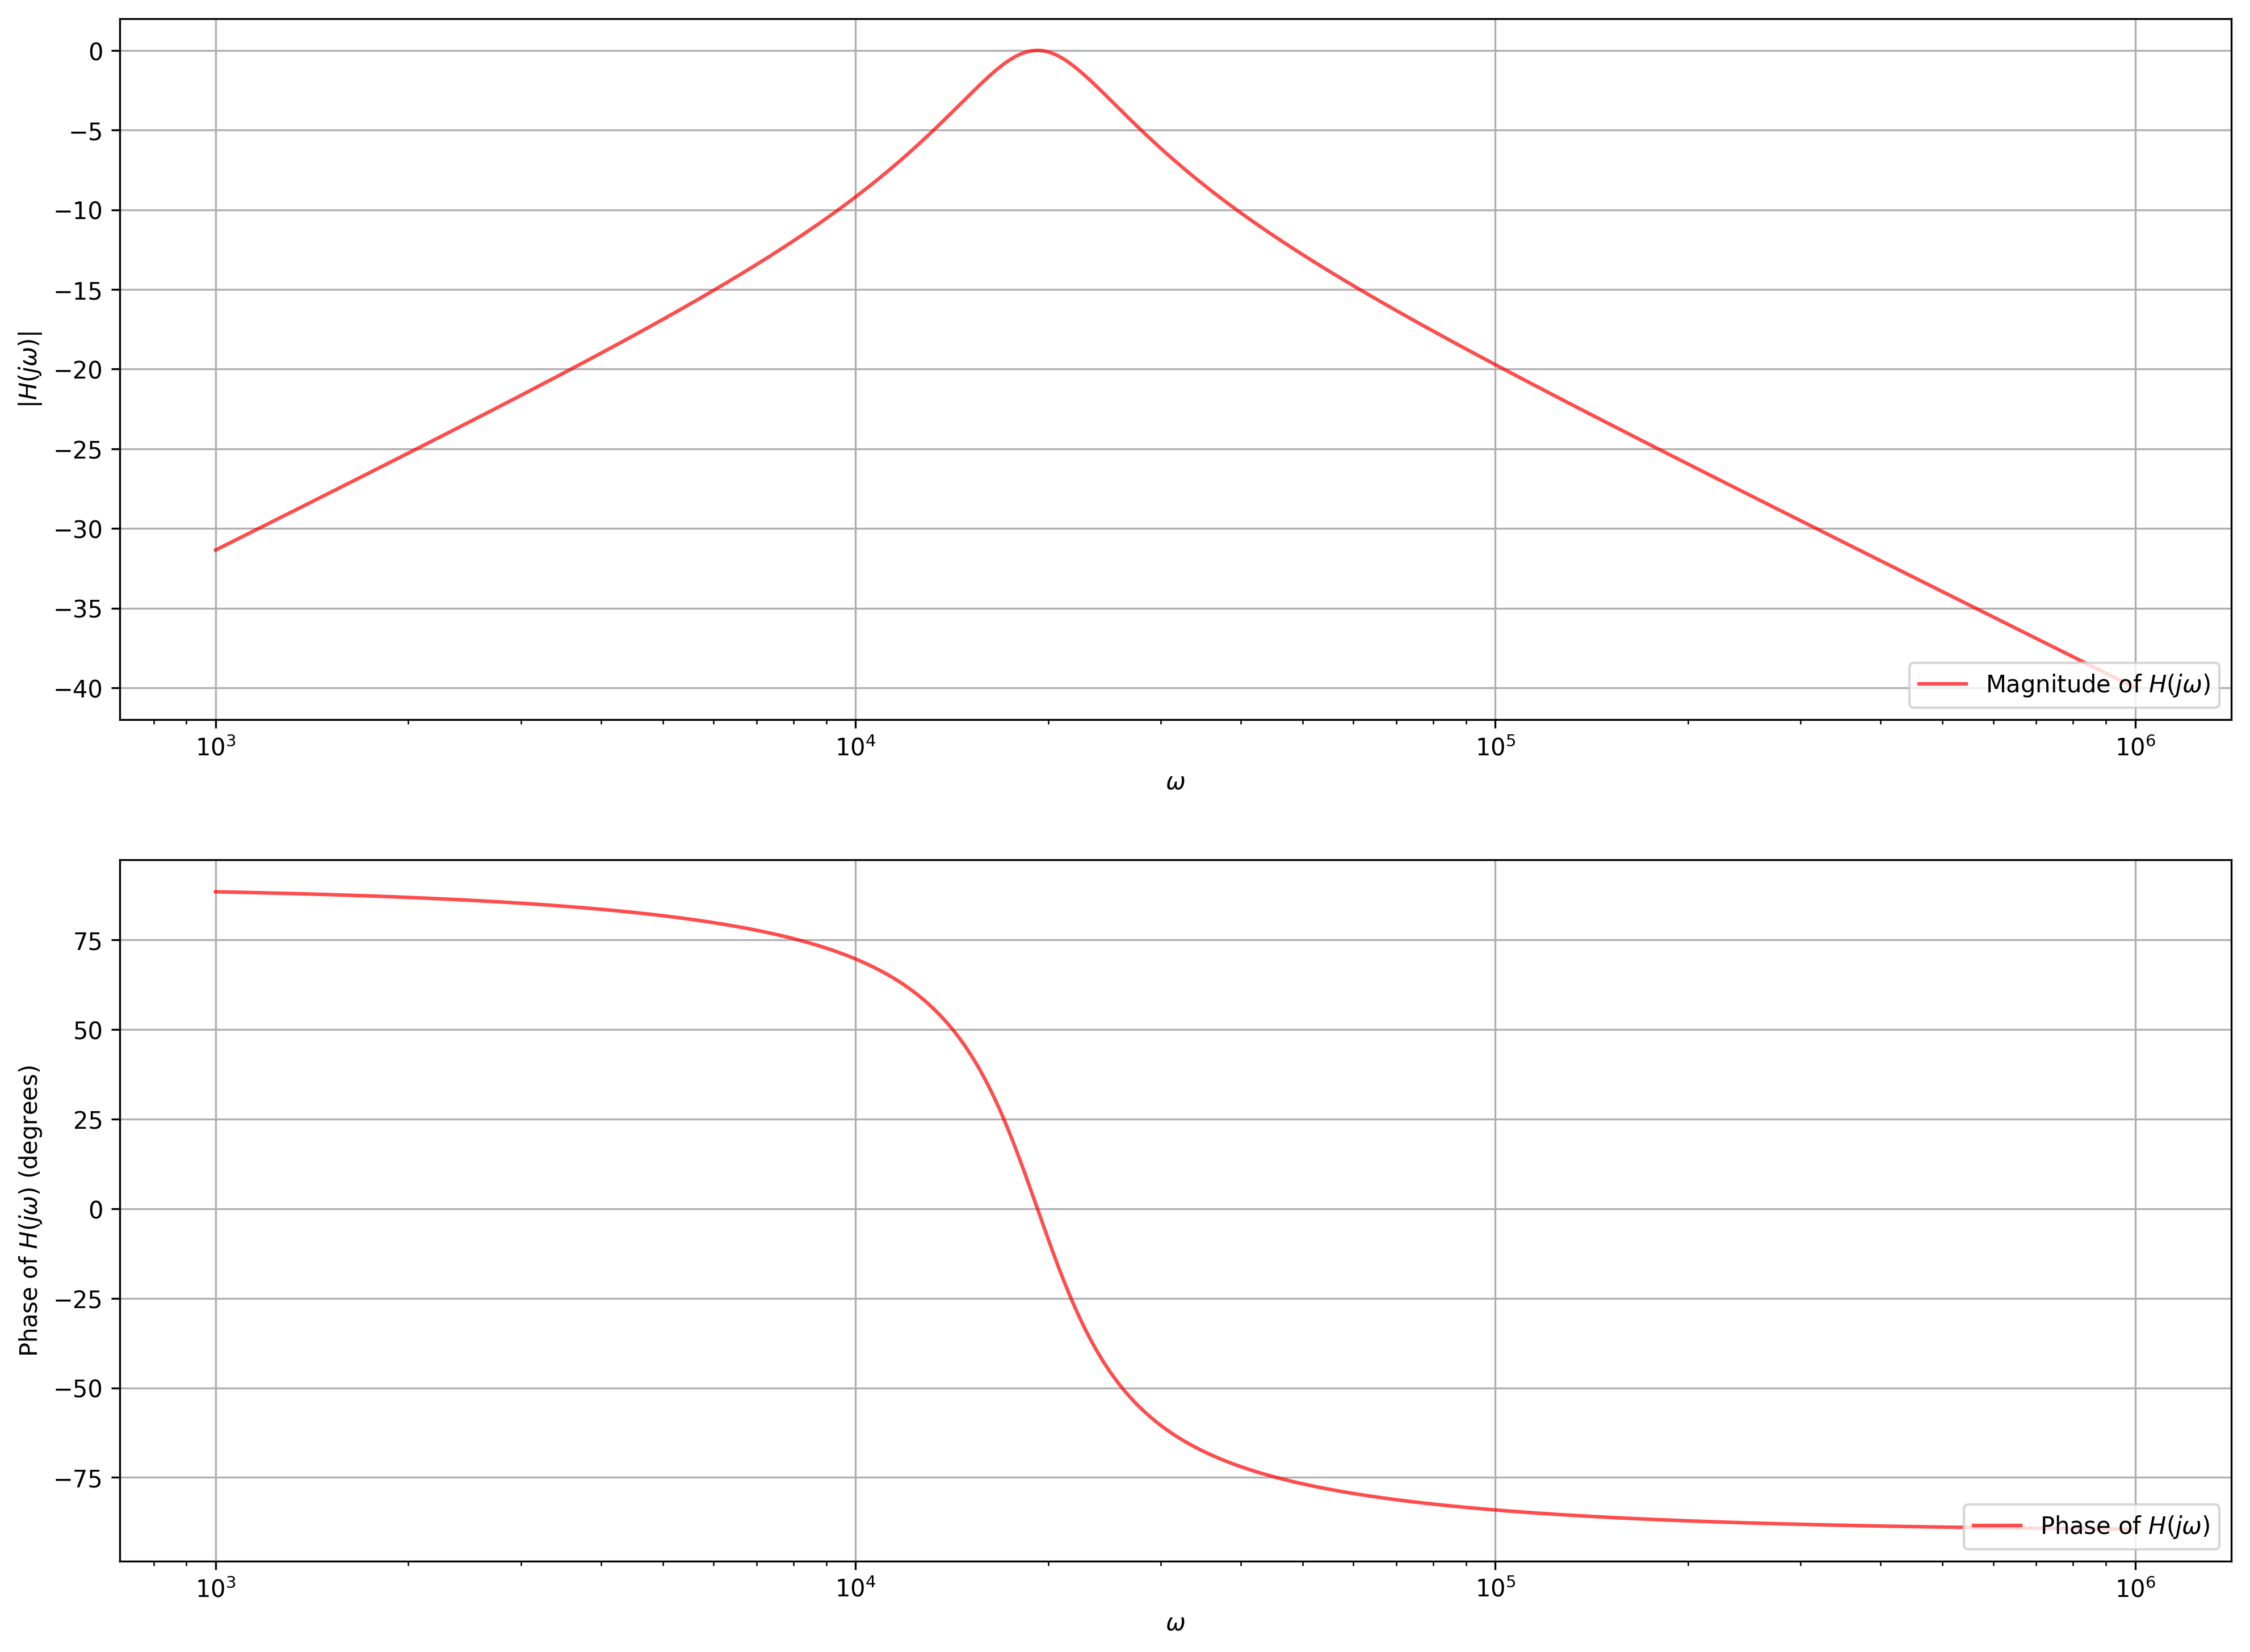

In [3]:
w = np.arange(1e3, 1e6 + step_size, step_size)
mag = h_mag(w)
phase = h_phase(w)
phase = [deg - 180 if deg > 90 else deg for deg in phase]

create_plot([w, w],
            [(mag, ), (phase, )],
            ["$\omega$", "$\omega$"],
            ["$|H(j\omega)|$", "Phase of $H(j\omega)$ (degrees)"],
            [("Magnitude of $H(j\omega)$", ), ("Phase of $H(j\omega)$", )], 2, mode="Log")

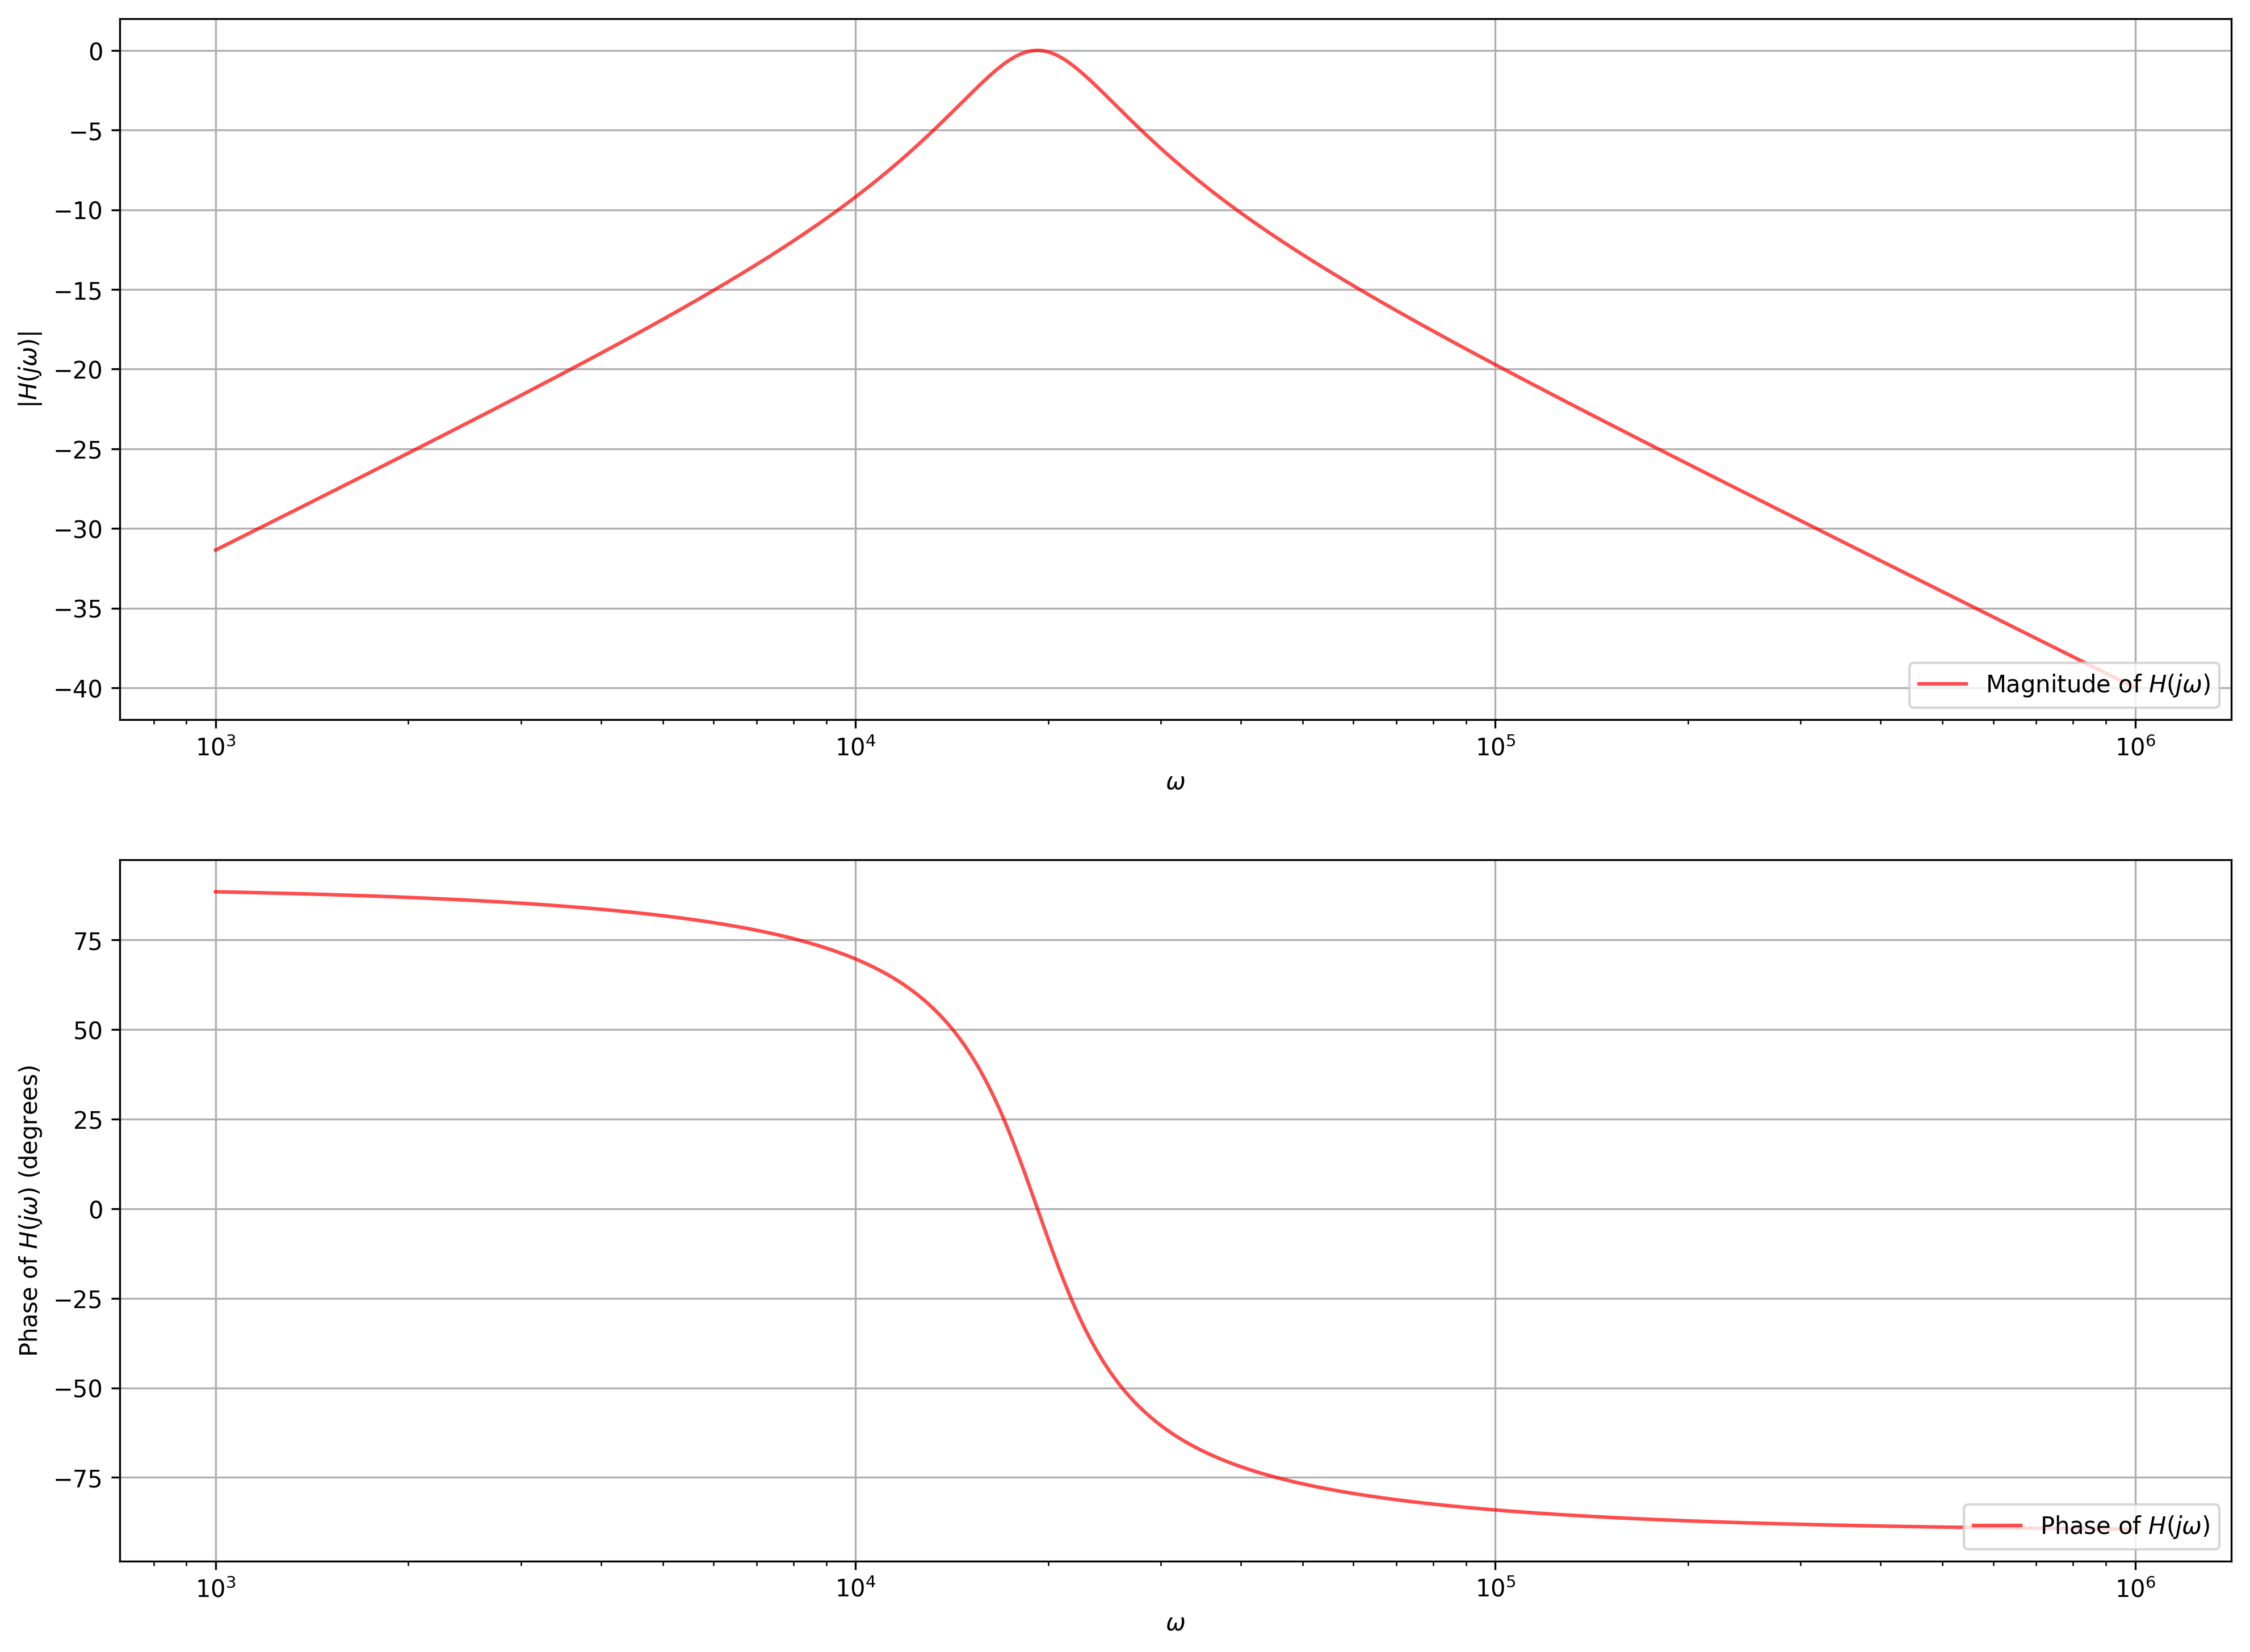

In [4]:
system = signal.TransferFunction([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)])
_, mag, phase = signal.bode(system, w)
create_plot([w, w], [(mag, ), (phase, )],
            ["$\omega$", "$\omega$"], ["$|H(j\omega)|$", "Phase of $H(j\omega)$ (degrees)"],
            [("Magnitude of $H(j\omega)$", ), ("Phase of $H(j\omega)$", )], 2, mode="Log")

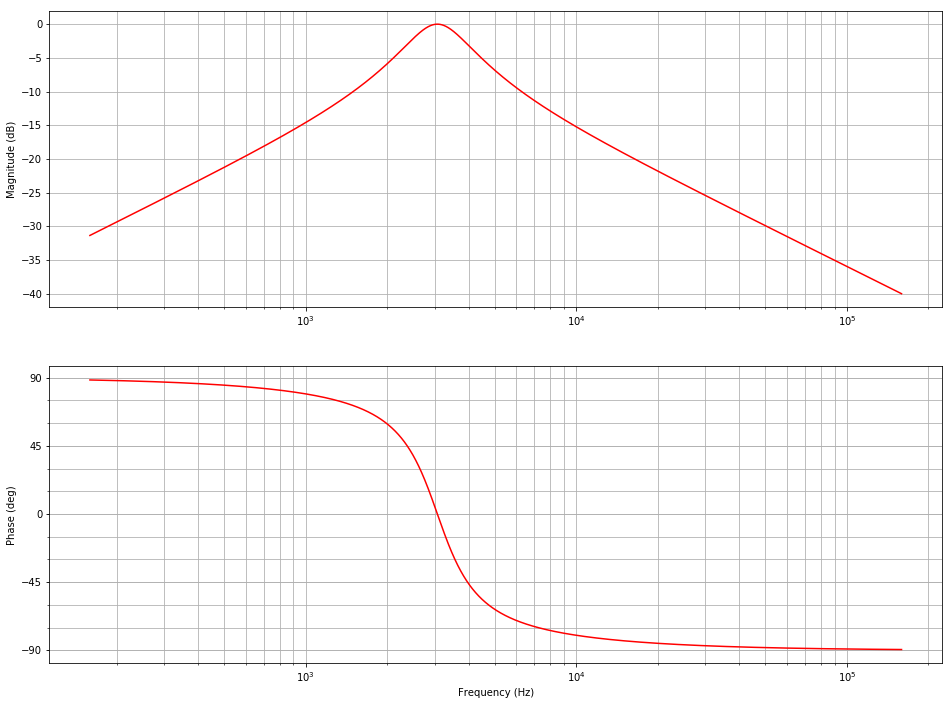

In [5]:
system = control.TransferFunction([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)])
plt.figure(figsize=(16, 12))
m, p, o = control.bode(system, w, dB=True, Hz=True, deg=True, Plot=True, color='r')

### Part 2

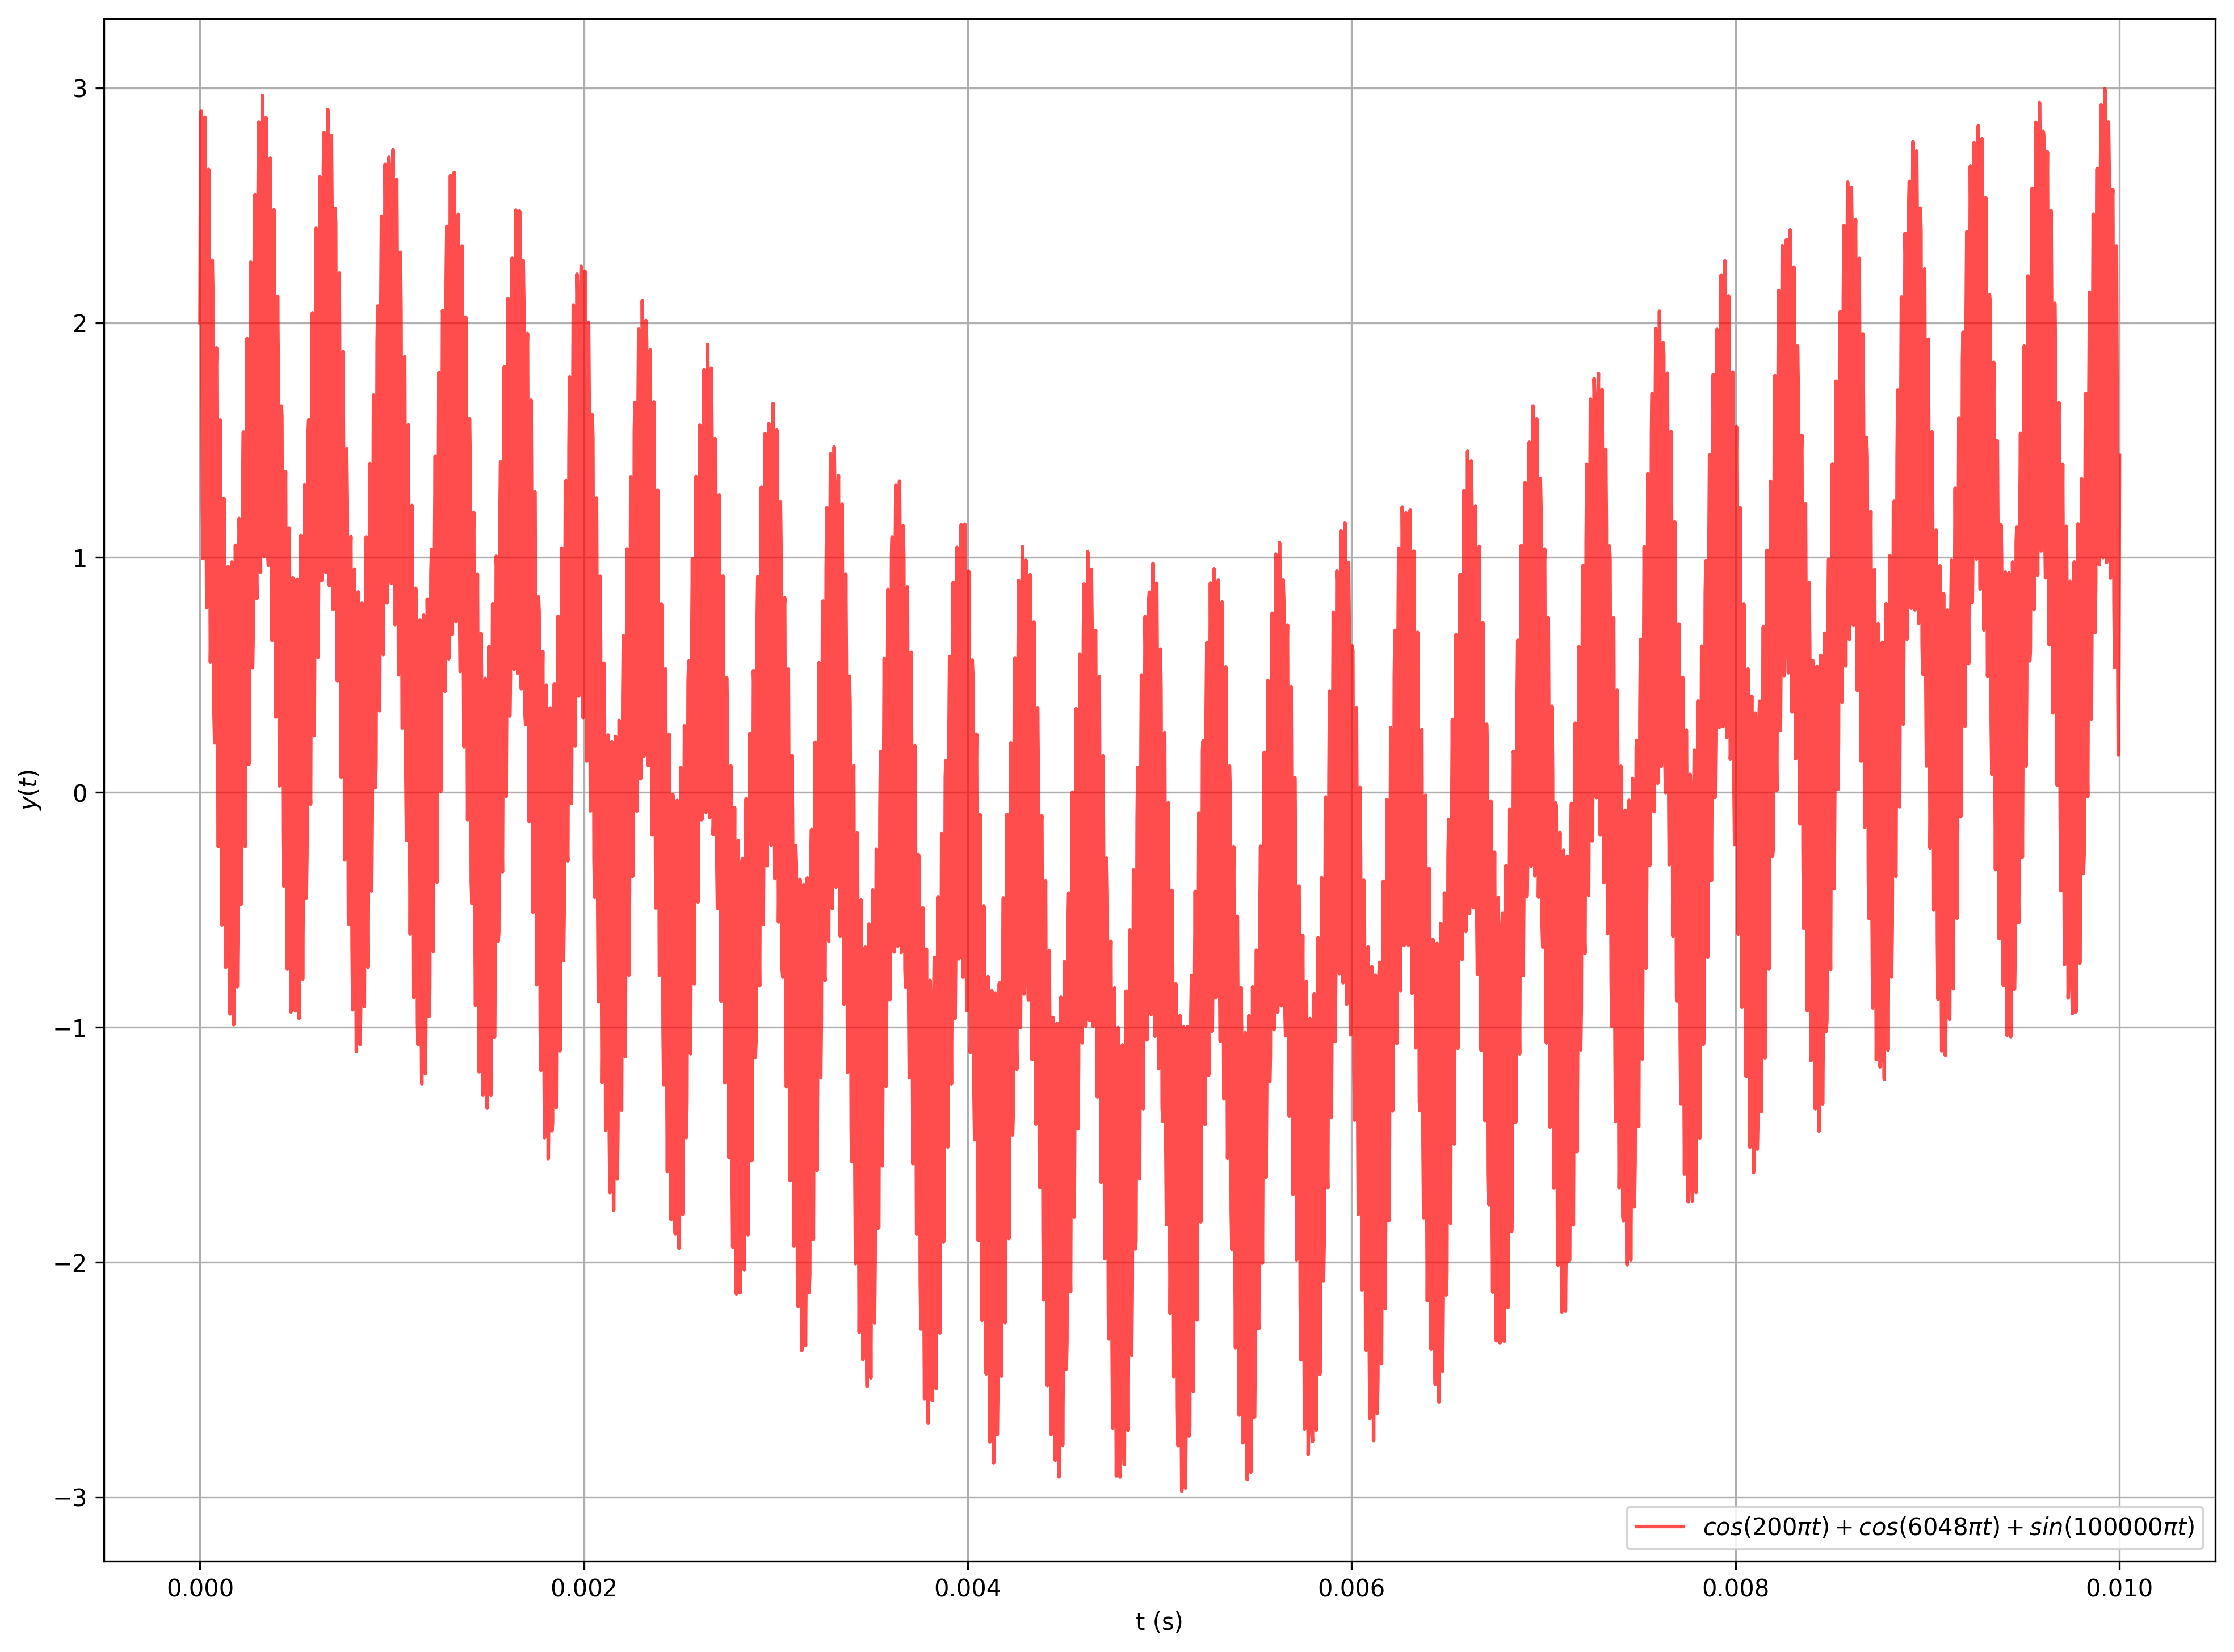

In [6]:
def sig(t):
    return (np.cos(200*np.pi*t) + np.cos(6048*np.pi*t) + np.sin(100000*np.pi*t))

fs = 2 * np.pi * 50000
step_size = 1 / fs
t = np.arange(0, 0.01 + step_size, step_size)
create_plot([t], [(sig(t), )], ["t (s)"], ["$y(t)$"],
            [("$cos(200\pi t)+cos(6048\pi t)+sin(100000\pi t)$", )], 1)

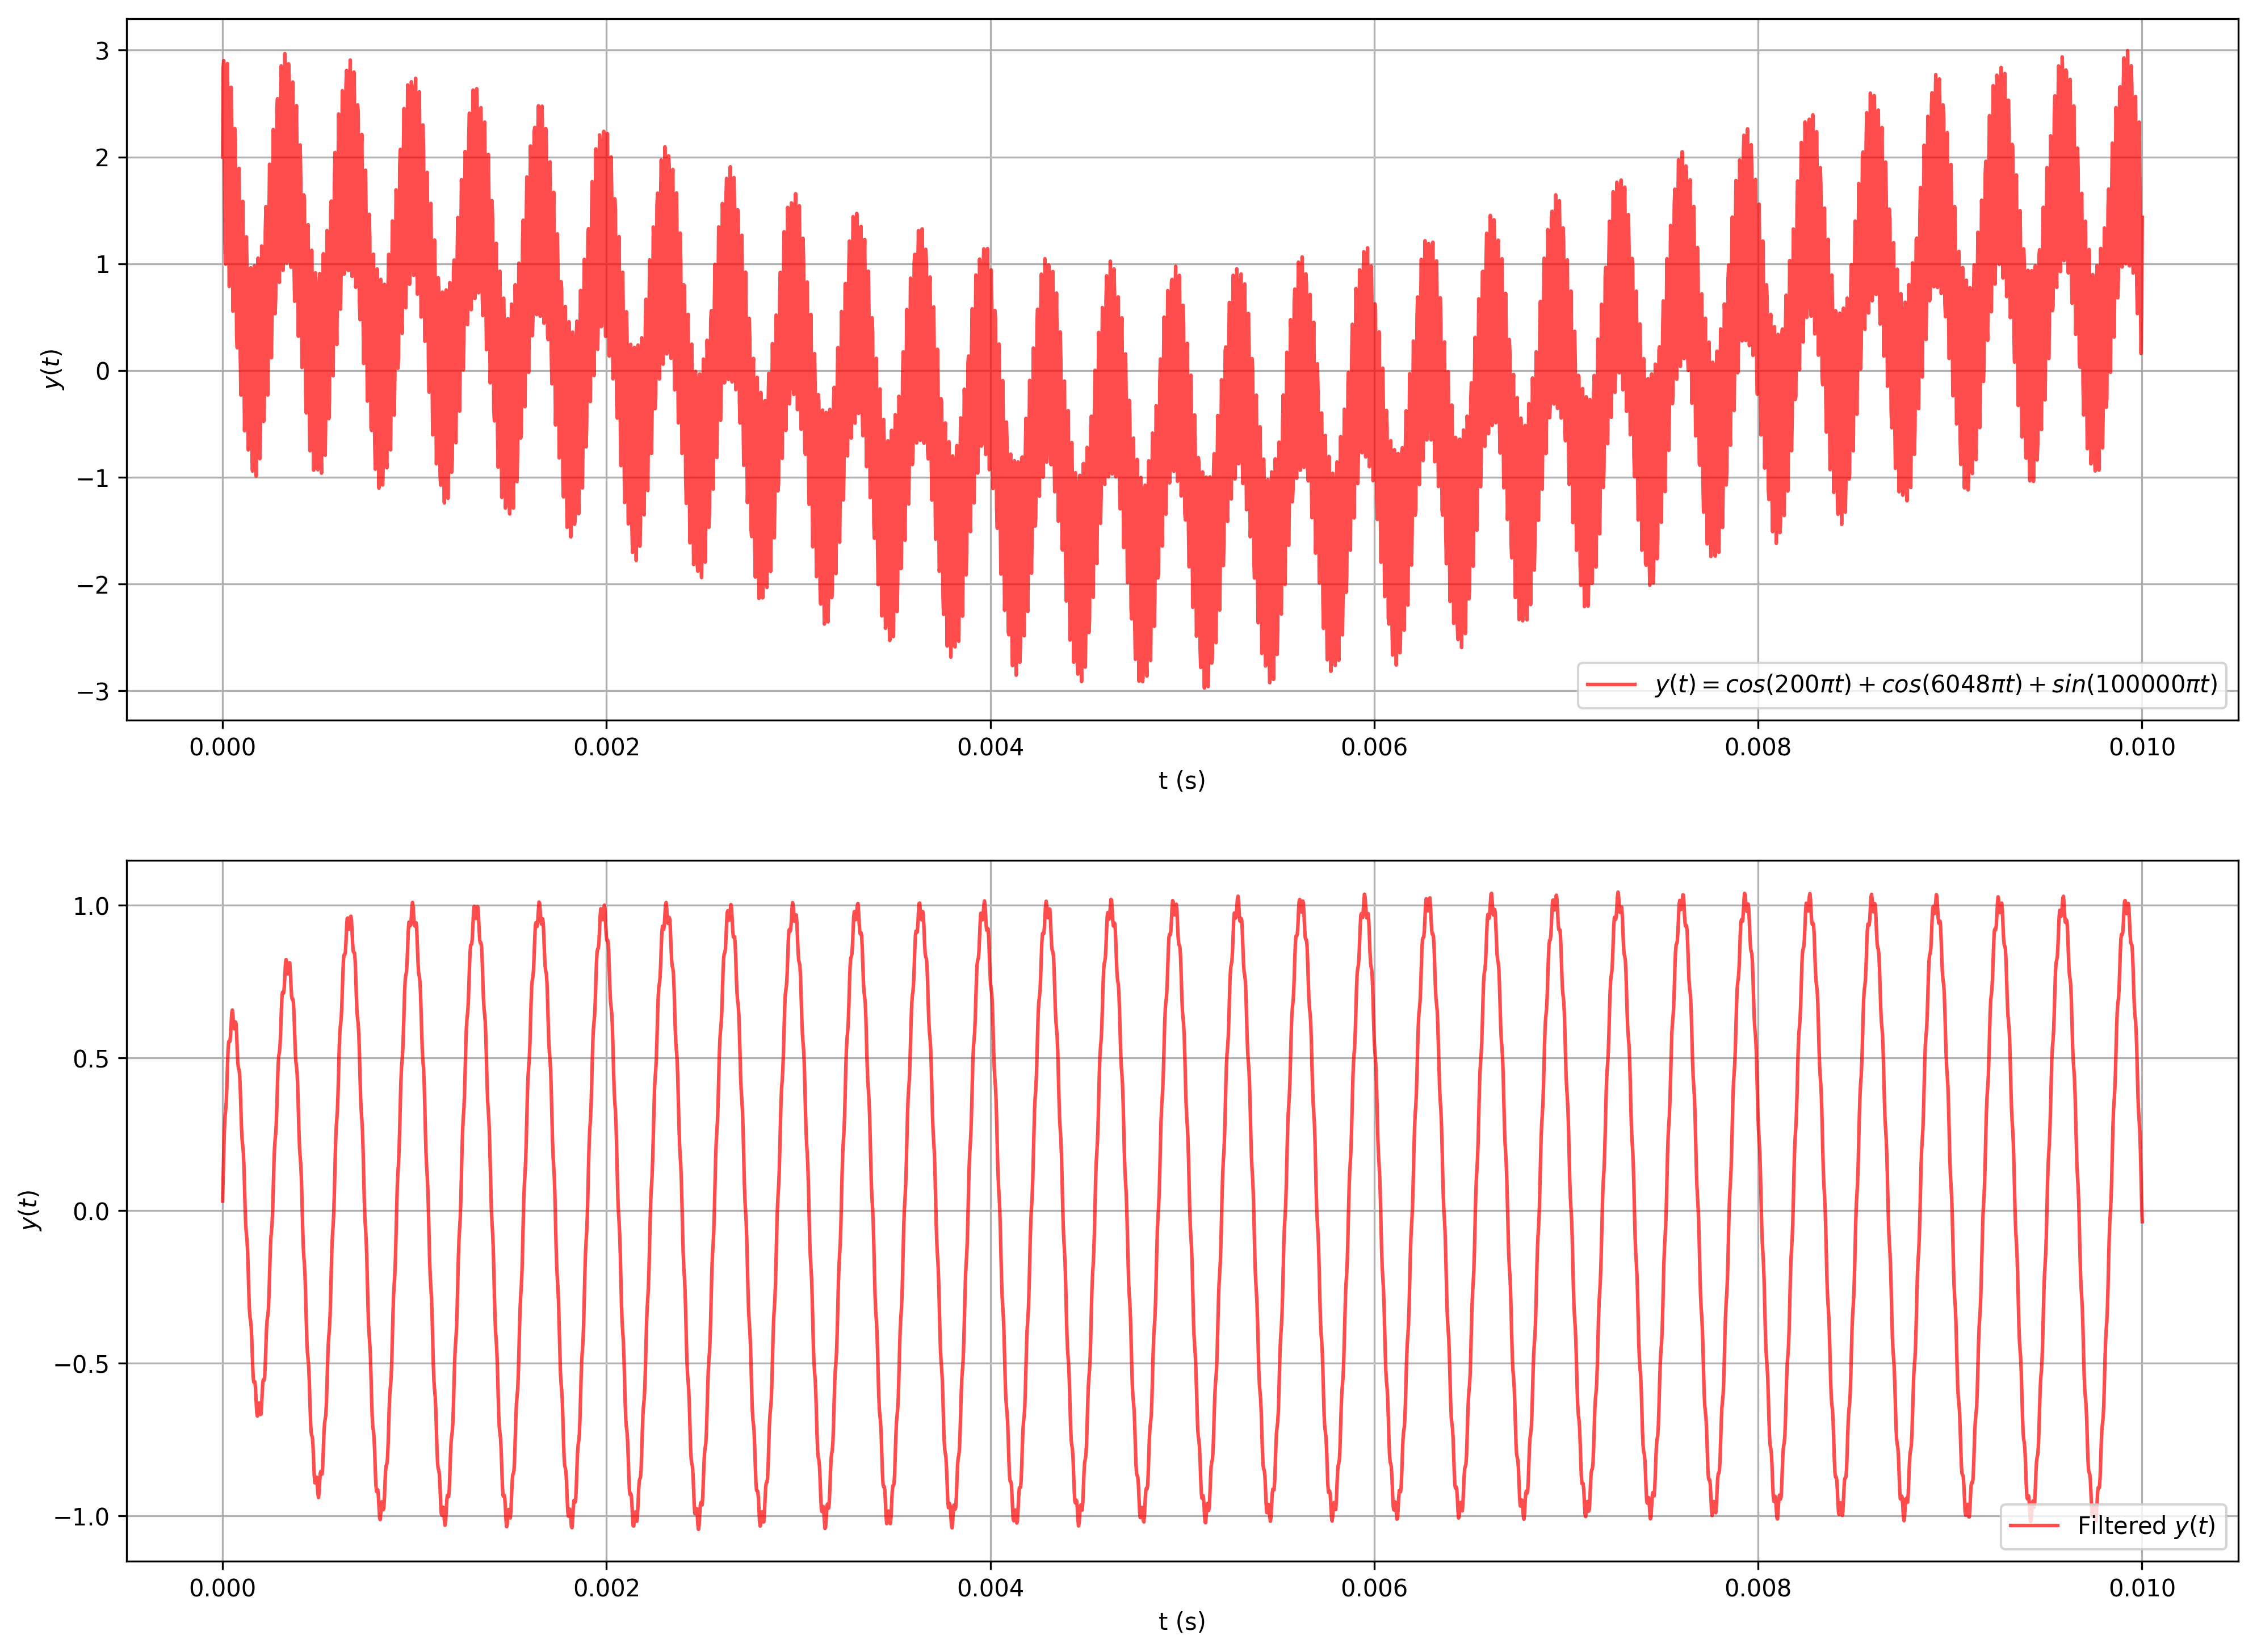

In [7]:
z_dom_num, z_dom_den = signal.bilinear([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)], fs)
filt  = signal.lfilter(z_dom_num, z_dom_den, sig(t))
create_plot([t, t], [(sig(t), ), (filt, )], ["t (s)", "t (s)"], ["$y(t)$", "$y(t)$"],
            [("$y(t)=cos(200\pi t)+cos(6048\pi t)+sin(100000\pi t)$", ), ("Filtered $y(t)$ ", )], 2)

### Questions
1. Our bode plots show that the filter is clearly a bandpass, meaning only 'middle' frequency signals pass through without much attenuation. This middle falls around $10^4$ radians/seconds. Passing the provided $x(t)$ function into this filter removes the extremely low and extremely high freqencies from this function. In particular, the 100 Hz and the 50,000 Hz component are removed, as they are attenuated so much due to the filter.
2. The `bilinear()` function converts the transfer function of our provided filter into the z-domain, and then we use the `lfilter()` function to pass a provided signal through this z-domain filter. The only thing that stands out to be for these functions are the importance of a correct `fs` value (the sampling frequency). In order to properly convert the function to the z-domain, the rate at which the filter is sampled is very important. Changing these values messes up the filtering of the input function.
3. If a different `fs` value is used for the `bilinear()` function some undesireable frequences pass through the filter and affect the output signal (by shifting the 'band' part of the filter). Larger sampling frequencies only let much smaller frequency signals through, like the 100 Hz signal, as shown below. On the other hand, larger sampling frequencies let much higher frequency signals through the system. Examples of these are shown below:

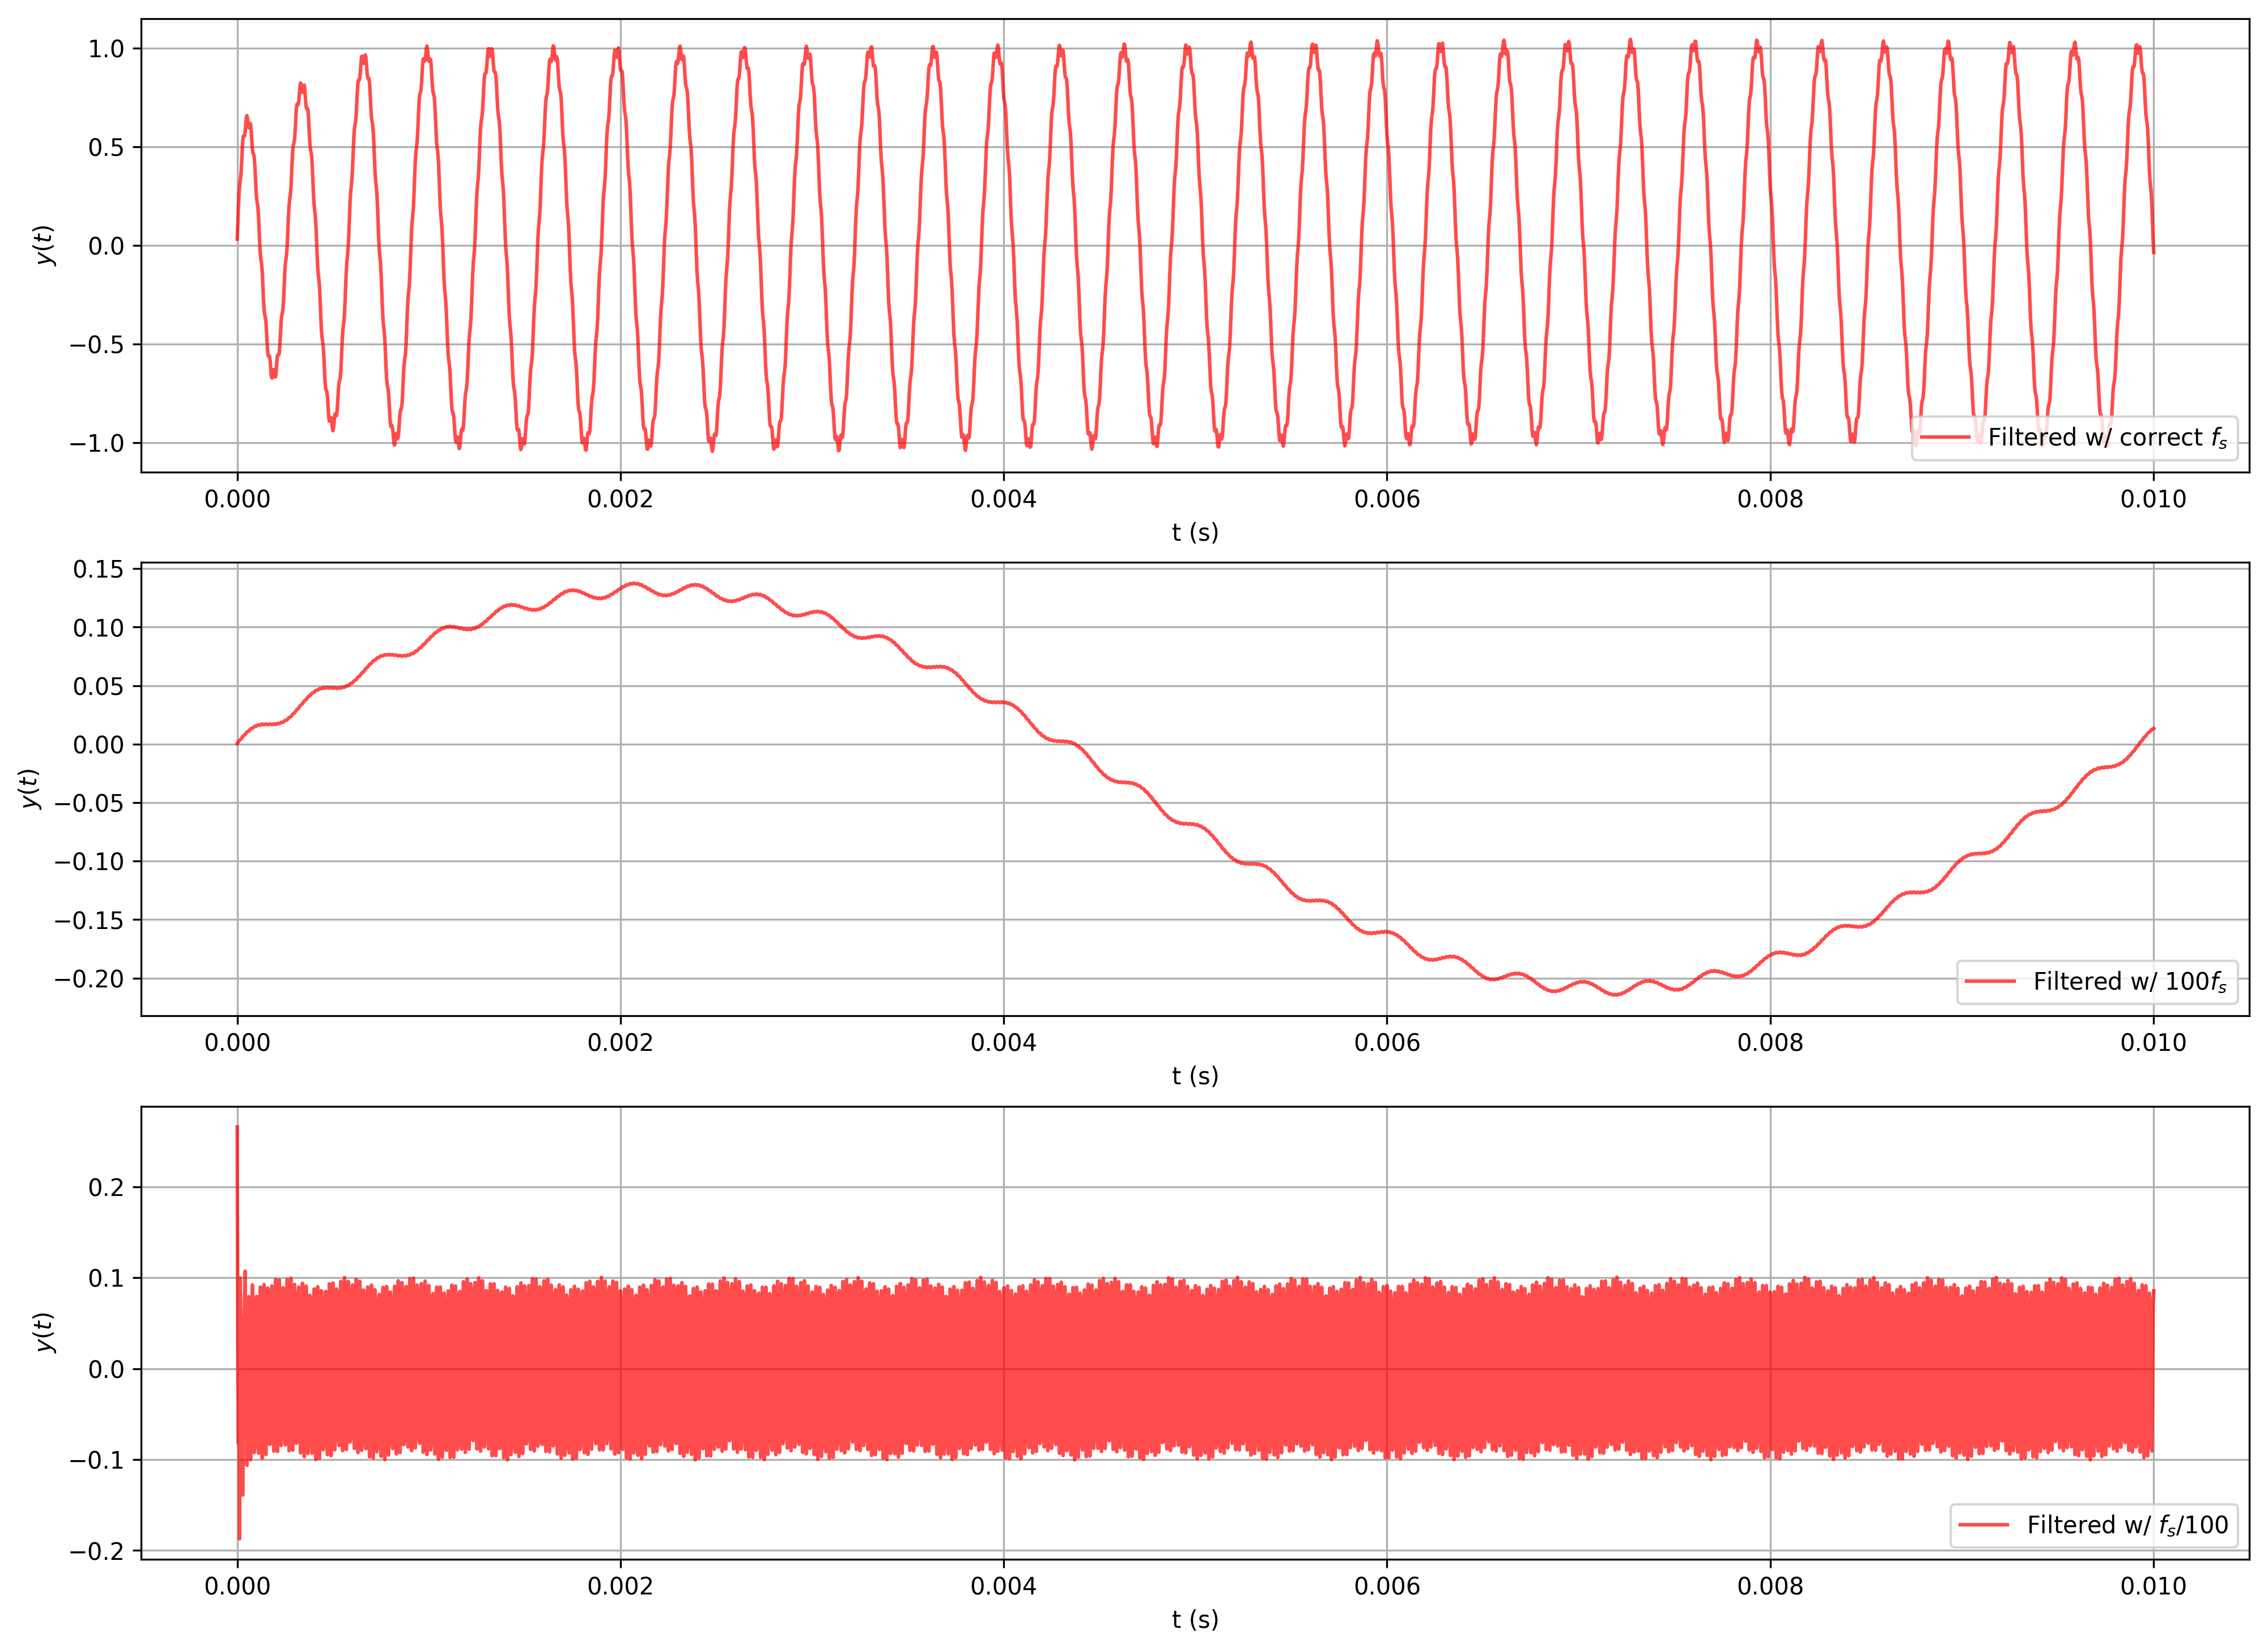

In [8]:
z_num_fs, z_den_fs = signal.bilinear([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)], fs)
z_num_big, z_den_big = signal.bilinear([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)], fs*100)
z_num_small, z_den_small = signal.bilinear([1/(r*c), 0], [1, 1/(r*c), 1/(l*c)], fs/100)
filt_fs    = signal.lfilter(z_num_fs, z_den_fs, sig(t))
filt_big   = signal.lfilter(z_num_big, z_den_big, sig(t))
filt_small = signal.lfilter(z_num_small, z_den_small, sig(t))
create_plot([t, t, t], [(filt_fs, ), (filt_big, ), (filt_small, )],
            ["t (s)", "t (s)", "t (s)"], ["$y(t)$", "$y(t)$", "$y(t)$"],
            [("Filtered w/ correct $f_s$", ),
             ("Filtered w/ $100f_s$ ", ),
             ("Filtered w/ $f_s/100$", )], 3)

4. I think the use on the `scipy.signal.bilinear()` function could be better explained. In particular this function because there is practically no documentation available online on how to use this function, or what each parameter is. Otherwise, I think the lab is very direct and easy to understand and follow.

### Conclusion
I think this lab was a great introduction into how to analyze frequency responses of systems using Python. Clearly there are many tools available for analyzing a specific transfer functions frequency response, and they all seem very powerful. The filtering portion of the lab was especially interesting, and could be really useful for the class.